In [1]:
import os
import warnings
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# for padding a list of variable length tensors to equal length
from torch.nn.utils.rnn import pad_sequence
# for packing a tensor containing padded sequences of variable length
from torch.nn.utils.rnn import pack_padded_sequence

import nltk
# for removing stop words like 'the', 'and', etc
# stop words don't provide useful information
from nltk.corpus import stopwords
# for tokenization
from nltk.tokenize import word_tokenize

# for counting the number of unique tokens
from collections import Counter


In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# Load the concatenated_MV file as a pandas DataFrame
file_path = '/content/sample_data/concatenated_MV.xlsx'  # Update this path to the actual file location
df_loreal = pd.read_excel(file_path)

# Shuffle the DataFrame
df_loreal = df_loreal.sample(frac=1).reset_index(drop=True)
# Display the first few rows of the DataFrame
df_loreal.head()

,description,dark_pigmentation,acne,eye_contour,homogeneity,lack_firmness,lack_radiance,pores,fine_lines,wrinkles_fine-lines,...,female,cleanse,prepare,treat,targeted,care,moisturize,protect,day,night
0,Vichy IdÃƒalia Smooth & Glow Energizing Moistu...,0,0,0,1,0,1,1,0,1,...,1,0,0,0,0,0,1,0,1,0
1,La Roche-Posay Pure Vitamin C Anti-Aging Face ...,0,0,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,1
2,Pure Nutrition Aloe Vera Moisturizing Day & Ni...,0,1,0,1,1,1,0,0,1,...,1,0,0,1,0,0,1,0,1,1
3,Vaseline Nourishing Face Facial Mask Sheet - S...,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,1,1
4,[By Wishtrend] Pro-Biome Balance Cream 1.69 Fl...,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,1


In [15]:
# Extract the output class names (column names excluding the text column)
output_classes = list(df_loreal.columns[1:34])  # Exclude the 'text_raw' column

num_classes = len(output_classes)

# Display the output
print(f"Number of output classes: {num_classes}")
print("List of output classes:")
print(output_classes)

Number of output classes: 33
List of output classes:
['dark_pigmentation', 'acne', 'eye_contour', 'homogeneity', 'lack_firmness', 'lack_radiance', 'pores', 'fine_lines', 'wrinkles_fine-lines', 'eye-wrinkles', 'undereye-bags', 'generic', '18-34', '35-54', '55-99', 'dry', 'normal', 'oily', 'combination', 'sensitivity-high', 'sensitivity-low', 'no_sensitivity', 'male', 'female', 'cleanse', 'prepare', 'treat', 'targeted', 'care', 'moisturize', 'protect', 'day', 'night']


In [5]:
# ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# set the stop words to the English mode
stop_words = set(stopwords.words('english'))

# define a function for pre-processing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # remove stop words
    return tokens

# Apply preprocessing to the 'text_raw' column
df_loreal["tokens"] = df_loreal["description"].apply(preprocess_text)

# Display first few tokenized samples
df_loreal[["description", "tokens"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,description,tokens
0,Vichy IdÃƒalia Smooth & Glow Energizing Moistu...,"[vichy, idãƒalia, smooth, &, glow, energizing,..."
1,La Roche-Posay Pure Vitamin C Anti-Aging Face ...,"[la, roche-posay, pure, vitamin, c, anti-aging..."
2,Pure Nutrition Aloe Vera Moisturizing Day & Ni...,"[pure, nutrition, aloe, vera, moisturizing, da..."
3,Vaseline Nourishing Face Facial Mask Sheet - S...,"[vaseline, nourishing, face, facial, mask, she..."
4,[By Wishtrend] Pro-Biome Balance Cream 1.69 Fl...,"[[, wishtrend, ], pro-biome, balance, cream, 1..."
...,...,...
6235,LOreal Paris Glycolic Bright Skin Brightening ...,"[loreal, paris, glycolic, bright, skin, bright..."
6236,L'Oreal® Paris RevitaLift® Volume Filler Moist...,"[l'oreal®, paris, revitalift®, volume, filler,..."
6237,It's Skin The Fresh Mask Sheet Lemon The Fresh...,"['s, skin, fresh, mask, sheet, lemon, fresh, m..."
6238,Blackhead Solutions by Clinique 7 Day Deep Por...,"[blackhead, solutions, clinique, 7, day, deep,..."


In [6]:
# build vocabulary
all_tokens = [token for tokens in df_loreal['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print('The number of unique tokens in the vocabulary:', len(token_counts))

The number of unique tokens in the vocabulary: 24064


In [ ]:
from scipy.stats import norm

# Assume token_counts is already defined from our vocabulary creation step:
# token_counts = Counter(all_tokens)

# Get an array of token frequencies
frequencies = np.array(list(token_counts.values()))

# Plot the histogram of token frequencies
# plt.figure(figsize=(10, 6))
# n, bins, patches = plt.hist(frequencies, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Token Frequency Histogram')

# # Fit a normal distribution to the frequency data
# mu, sigma = norm.fit(frequencies)
# print(f"Fitted Normal Distribution: mu = {mu:.2f}, sigma = {sigma:.2f}")

# # Set the x-axis maximum to 10,000
# xmin, _ = plt.xlim()
# xmax = 5000
# plt.xlim(xmin, xmax)

# # Create a range of values for plotting the PDF of the fitted normal distribution
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, sigma)

# # Plot the fitted normal distribution curve
# plt.plot(x, p, 'r', linewidth=2, label=f'Normal fit (mu={mu:.2f}, sigma={sigma:.2f})')
# plt.xlabel('Token Frequency')
# plt.ylabel('Density')
# plt.title('Token Frequency Distribution with Fitted Normal Curve')
# plt.legend()
# plt.show()



In [7]:
# Set vocabulary size (excluding special tokens)
vocab_size = 24064  # Adjust as needed

# Keep only the most common words (excluding special tokens)
common_tokens = token_counts.most_common(vocab_size - 2)  # Reserve space for <PAD> and <UNK>

# Create token-to-index mappings
token_to_idx = {token: idx + 2 for idx, (token, _) in enumerate(common_tokens)}

# Special tokens
token_to_idx["<PAD>"] = 0  # Padding token
token_to_idx["<UNK>"] = 1  # Unknown token

# Create index-to-token mapping (for decoding)
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

# Define a function to encode tokens into integer sequences
def encode_tokens(tokens):
    return [token_to_idx.get(token, token_to_idx["<UNK>"]) for token in tokens]

# Apply encoding to the dataset
df_loreal["encoded_tokens"] = df_loreal["tokens"].apply(encode_tokens)

# Display first few rows with encoded tokens
df_loreal[["description", "tokens", "encoded_tokens"]].head()

,description,tokens,encoded_tokens
0,Vichy IdÃƒalia Smooth & Glow Energizing Moistu...,"[vichy, idãƒalia, smooth, &, glow, energizing,...","[544, 12863, 42, 14, 109, 756, 20, 2, 1192, 84..."
1,La Roche-Posay Pure Vitamin C Anti-Aging Face ...,"[la, roche-posay, pure, vitamin, c, anti-aging...","[233, 307, 117, 24, 53, 99, 6, 16, 1500, 1539,..."
2,Pure Nutrition Aloe Vera Moisturizing Day & Ni...,"[pure, nutrition, aloe, vera, moisturizing, da...","[117, 1243, 154, 273, 76, 40, 14, 59, 7, 262, ..."
3,Vaseline Nourishing Face Facial Mask Sheet - S...,"[vaseline, nourishing, face, facial, mask, she...","[1849, 215, 6, 31, 28, 230, 9, 4, 47, 189, 2, ..."
4,[By Wishtrend] Pro-Biome Balance Cream 1.69 Fl...,"[[, wishtrend, ], pro-biome, balance, cream, 1...","[1054, 7854, 946, 6795, 279, 7, 1192, 84, 17, ..."


In [40]:
# Define a custom Dataset class
class LOREALMultiLabelDataset(Dataset):
    def __init__(self, encoded_tokens_list, labels):
        self.encoded_tokens_list = encoded_tokens_list
        self.labels = labels

    def __len__(self):
        return len(self.encoded_tokens_list)

    def __getitem__(self, idx):
        X = self.encoded_tokens_list[idx]
        y = self.labels[idx]

        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.float)  # Multi-label classification requires float

        return X, y

# Define a collate function to handle variable sequence lengths
def collate_batch(batch):
    batch_X, batch_y, batch_length = [], [], []

    for (X, y) in batch:
        batch_X.append(X)
        batch_y.append(y)
        batch_length.append(len(X))

    # Convert batch_length to tensor
    batch_length = torch.tensor(batch_length, dtype=torch.int64)
    batch_y = torch.stack(batch_y)  # Stack labels into a tensor

    # Pad sequences to equal length
    batch_X = pad_sequence(batch_X, batch_first=True)

    return batch_X, batch_y, batch_length

In [68]:

# Create a single dataset instance from your encoded tokens and multi-label targets
ds = LOREALMultiLabelDataset(
    df_loreal["encoded_tokens"].tolist(),
    df_loreal.iloc[:, 1:34].values  # columns 2 to 33 for labels
)
train_val_ds, test_ds = random_split(ds, [0.8, 0.2])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

In [69]:
# Define batch size
batch_size = 32

# Create DataLoader instances
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Display dataset statistics
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Train dataset size: 3994
Validation dataset size: 998
Test dataset size: 1248


In [70]:
import torch.nn as nn

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MultiLabelBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=1, dropout=0.3):
        super(MultiLabelBiLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)

        # Bidirectional LSTM layer
        # When using bidirectional=True, the hidden state size is doubled.
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Fully connected layer: input size is hidden_size*2 due to bidirectionality
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x, lengths):
        # x: [batch_size, seq_len]
        # Convert token IDs to embeddings and apply dropout
        x = self.dropout(self.embedding(x))

        # Pack the padded sequence for efficient processing by the LSTM
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed_x)

        # Option 1: Use the concatenation of the last hidden states from both directions.
        # h: [num_layers*2, batch_size, hidden_size]
        # For a bidirectional LSTM, the last layer's forward hidden state is h[-2] and the backward is h[-1].
        h_forward = h[-2, :, :]
        h_backward = h[-1, :, :]
        h_final = torch.cat((h_forward, h_backward), dim=1)

        # Option 2: Alternatively, you can use max pooling over time.
        # Uncomment the following lines if you want to try pooling instead:
        # out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # h_final, _ = torch.max(out, dim=1)

        # Fully connected layer; note that no sigmoid is applied here.
        # Use BCEWithLogitsLoss during training.
        logits = self.fc(h_final)
        return logits



In [16]:
# Debug
print(num_classes)

33


In [71]:
# Define model parameters
embed_size = 200
hidden_size = 256
num_layers = 1
dropout = 0.3

# Create the model instance
model = MultiLabelBiLSTM(vocab_size, embed_size, hidden_size, num_classes, num_layers, dropout)

# Move model to computation device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model architecture
print(model)

MultiLabelBiLSTM(
  (embedding): Embedding(24064, 200)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(200, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=33, bias=True)
)


In [72]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y, lens in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            logits = model(X, lens)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y, lens in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y, lens = X.to(device), y.to(device), lens.to(device)
                logits = model(X, lens)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}')
            patience_counter += 1
            if (val_epoch_loss + 0.00009) < min_val_loss:
                patience_counter = 0
                print('Reset patience counter\n')
            min_val_loss = val_epoch_loss
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [73]:
# define the training hyper-parameters
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-1
weight_decay = 1e-6
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 500
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
)
saved_path_prefix = 'loreal_product_classifier'

In [74]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|██████████| 32/32 [00:00<00:00, 126.81it/s]


Epoch 1: train loss = 0.627145, val loss = 0.548066, time consumed = 0:00:03
Model saved after epoch 1
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 115.48it/s]


Epoch 2: train loss = 0.506746, val loss = 0.471404, time consumed = 0:00:07
Model saved after epoch 2
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 127.27it/s]


Epoch 3: train loss = 0.463143, val loss = 0.450063, time consumed = 0:00:10
Model saved after epoch 3
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 118.55it/s]


Epoch 4: train loss = 0.446822, val loss = 0.438350, time consumed = 0:00:13
Model saved after epoch 4
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 119.63it/s]


Epoch 5: train loss = 0.435735, val loss = 0.429545, time consumed = 0:00:17
Model saved after epoch 5
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.69it/s]


Epoch 6: train loss = 0.426721, val loss = 0.422625, time consumed = 0:00:20
Model saved after epoch 6
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.68it/s]


Epoch 7: train loss = 0.420036, val loss = 0.417251, time consumed = 0:00:24
Model saved after epoch 7
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 126.42it/s]


Epoch 8: train loss = 0.414176, val loss = 0.413331, time consumed = 0:00:27
Model saved after epoch 8
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 90.07it/s]


Epoch 9: train loss = 0.410046, val loss = 0.410562, time consumed = 0:00:31
Model saved after epoch 9
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.99it/s]


Epoch 10: train loss = 0.406742, val loss = 0.408742, time consumed = 0:00:34
Model saved after epoch 10
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.11it/s]


Epoch 11: train loss = 0.404657, val loss = 0.407418, time consumed = 0:00:37
Model saved after epoch 11
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 125.61it/s]


Epoch 12: train loss = 0.403075, val loss = 0.406664, time consumed = 0:00:40
Model saved after epoch 12
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.93it/s]


Epoch 13: train loss = 0.401939, val loss = 0.406127, time consumed = 0:00:44
Model saved after epoch 13
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 114.76it/s]


Epoch 14: train loss = 0.400696, val loss = 0.405664, time consumed = 0:00:47
Model saved after epoch 14
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 126.62it/s]


Epoch 15: train loss = 0.400076, val loss = 0.405208, time consumed = 0:00:50
Model saved after epoch 15
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 90.14it/s]


Epoch 16: train loss = 0.399502, val loss = 0.404859, time consumed = 0:00:54
Model saved after epoch 16
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.25it/s]


Epoch 17: train loss = 0.398718, val loss = 0.404470, time consumed = 0:00:58
Model saved after epoch 17
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 120.46it/s]


Epoch 18: train loss = 0.398163, val loss = 0.404109, time consumed = 0:01:01
Model saved after epoch 18
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 125.81it/s]


Epoch 19: train loss = 0.397823, val loss = 0.403738, time consumed = 0:01:04
Model saved after epoch 19
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 125.45it/s]


Epoch 20: train loss = 0.397146, val loss = 0.403251, time consumed = 0:01:08
Model saved after epoch 20
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 119.20it/s]


Epoch 21: train loss = 0.396615, val loss = 0.402789, time consumed = 0:01:11
Model saved after epoch 21
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.06it/s]


Epoch 22: train loss = 0.395715, val loss = 0.402320, time consumed = 0:01:14
Model saved after epoch 22
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 93.94it/s]


Epoch 23: train loss = 0.395301, val loss = 0.401785, time consumed = 0:01:17
Model saved after epoch 23
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.33it/s]


Epoch 24: train loss = 0.394485, val loss = 0.401314, time consumed = 0:01:21
Model saved after epoch 24
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.00it/s]


Epoch 25: train loss = 0.394042, val loss = 0.400723, time consumed = 0:01:24
Model saved after epoch 25
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.56it/s]


Epoch 26: train loss = 0.393015, val loss = 0.400143, time consumed = 0:01:27
Model saved after epoch 26
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.53it/s]


Epoch 27: train loss = 0.392621, val loss = 0.399639, time consumed = 0:01:31
Model saved after epoch 27
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 127.85it/s]


Epoch 28: train loss = 0.391896, val loss = 0.399057, time consumed = 0:01:34
Model saved after epoch 28
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.46it/s]


Epoch 29: train loss = 0.391099, val loss = 0.398333, time consumed = 0:01:38
Model saved after epoch 29
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.64it/s]


Epoch 30: train loss = 0.390295, val loss = 0.397751, time consumed = 0:01:41
Model saved after epoch 30
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.67it/s]


Epoch 31: train loss = 0.389475, val loss = 0.397099, time consumed = 0:01:45
Model saved after epoch 31
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 126.89it/s]


Epoch 32: train loss = 0.388344, val loss = 0.396278, time consumed = 0:01:48
Model saved after epoch 32
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 118.79it/s]


Epoch 33: train loss = 0.387776, val loss = 0.395518, time consumed = 0:01:51
Model saved after epoch 33
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 89.04it/s]


Epoch 34: train loss = 0.386722, val loss = 0.394763, time consumed = 0:01:55
Model saved after epoch 34
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.33it/s]


Epoch 35: train loss = 0.385649, val loss = 0.393828, time consumed = 0:01:58
Model saved after epoch 35
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.32it/s]


Epoch 36: train loss = 0.385086, val loss = 0.392919, time consumed = 0:02:01
Model saved after epoch 36
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 120.96it/s]


Epoch 37: train loss = 0.383888, val loss = 0.392098, time consumed = 0:02:04
Model saved after epoch 37
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 126.59it/s]


Epoch 38: train loss = 0.382814, val loss = 0.390979, time consumed = 0:02:08
Model saved after epoch 38
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.43it/s]


Epoch 39: train loss = 0.381878, val loss = 0.389859, time consumed = 0:02:11
Model saved after epoch 39
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 128.74it/s]


Epoch 40: train loss = 0.380259, val loss = 0.388746, time consumed = 0:02:14
Model saved after epoch 40
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 90.29it/s]


Epoch 41: train loss = 0.379038, val loss = 0.387625, time consumed = 0:02:18
Model saved after epoch 41
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 127.60it/s]


Epoch 42: train loss = 0.378157, val loss = 0.386229, time consumed = 0:02:21
Model saved after epoch 42
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 125.06it/s]


Epoch 43: train loss = 0.376523, val loss = 0.384779, time consumed = 0:02:25
Model saved after epoch 43
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.74it/s]


Epoch 44: train loss = 0.375042, val loss = 0.383271, time consumed = 0:02:28
Model saved after epoch 44
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 120.23it/s]


Epoch 45: train loss = 0.373160, val loss = 0.381653, time consumed = 0:02:32
Model saved after epoch 45
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.56it/s]


Epoch 46: train loss = 0.371684, val loss = 0.379895, time consumed = 0:02:35
Model saved after epoch 46
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.81it/s]


Epoch 47: train loss = 0.369995, val loss = 0.377922, time consumed = 0:02:38
Model saved after epoch 47
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 83.06it/s]


Epoch 48: train loss = 0.367879, val loss = 0.375947, time consumed = 0:02:41
Model saved after epoch 48
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.46it/s]


Epoch 49: train loss = 0.365679, val loss = 0.373852, time consumed = 0:02:45
Model saved after epoch 49
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.57it/s]


Epoch 50: train loss = 0.364016, val loss = 0.371707, time consumed = 0:02:48
Model saved after epoch 50
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.04it/s]


Epoch 51: train loss = 0.361774, val loss = 0.369169, time consumed = 0:02:52
Model saved after epoch 51
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.52it/s]


Epoch 52: train loss = 0.359785, val loss = 0.366826, time consumed = 0:02:56
Model saved after epoch 52
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 119.95it/s]


Epoch 53: train loss = 0.357291, val loss = 0.364367, time consumed = 0:02:59
Model saved after epoch 53
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 117.97it/s]


Epoch 54: train loss = 0.355305, val loss = 0.362224, time consumed = 0:03:02
Model saved after epoch 54
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 97.08it/s]


Epoch 55: train loss = 0.353292, val loss = 0.360139, time consumed = 0:03:05
Model saved after epoch 55
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 116.75it/s]


Epoch 56: train loss = 0.351340, val loss = 0.358242, time consumed = 0:03:09
Model saved after epoch 56
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.99it/s]


Epoch 57: train loss = 0.349227, val loss = 0.356295, time consumed = 0:03:13
Model saved after epoch 57
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.17it/s]


Epoch 58: train loss = 0.347165, val loss = 0.354545, time consumed = 0:03:16
Model saved after epoch 58
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 118.27it/s]


Epoch 59: train loss = 0.344974, val loss = 0.352695, time consumed = 0:03:20
Model saved after epoch 59
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 121.00it/s]


Epoch 60: train loss = 0.343282, val loss = 0.350858, time consumed = 0:03:23
Model saved after epoch 60
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 118.01it/s]


Epoch 61: train loss = 0.341070, val loss = 0.349366, time consumed = 0:03:27
Model saved after epoch 61
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 90.80it/s]


Epoch 62: train loss = 0.339231, val loss = 0.347315, time consumed = 0:03:30
Model saved after epoch 62
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 116.04it/s]


Epoch 63: train loss = 0.337480, val loss = 0.345461, time consumed = 0:03:34
Model saved after epoch 63
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.27it/s]


Epoch 64: train loss = 0.335005, val loss = 0.343772, time consumed = 0:03:37
Model saved after epoch 64
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 125.36it/s]


Epoch 65: train loss = 0.333545, val loss = 0.341971, time consumed = 0:03:40
Model saved after epoch 65
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.91it/s]


Epoch 66: train loss = 0.331097, val loss = 0.340415, time consumed = 0:03:44
Model saved after epoch 66
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 119.69it/s]


Epoch 67: train loss = 0.329028, val loss = 0.339088, time consumed = 0:03:48
Model saved after epoch 67
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.89it/s]


Epoch 68: train loss = 0.326480, val loss = 0.336645, time consumed = 0:03:51
Model saved after epoch 68
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 85.40it/s]


Epoch 69: train loss = 0.325103, val loss = 0.334376, time consumed = 0:03:55
Model saved after epoch 69
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 117.41it/s]


Epoch 70: train loss = 0.322890, val loss = 0.333044, time consumed = 0:03:58
Model saved after epoch 70
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.89it/s]


Epoch 71: train loss = 0.319686, val loss = 0.333440, time consumed = 0:04:01


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 117.57it/s]


Epoch 72: train loss = 0.318682, val loss = 0.329719, time consumed = 0:04:05
Model saved after epoch 72
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 126.29it/s]


Epoch 73: train loss = 0.317097, val loss = 0.328271, time consumed = 0:04:08
Model saved after epoch 73
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 119.43it/s]


Epoch 74: train loss = 0.314848, val loss = 0.334741, time consumed = 0:04:12


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 119.22it/s]


Epoch 75: train loss = 0.312711, val loss = 0.325659, time consumed = 0:04:15
Model saved after epoch 75
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 94.31it/s]


Epoch 76: train loss = 0.311618, val loss = 0.324007, time consumed = 0:04:19
Model saved after epoch 76
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 116.47it/s]


Epoch 77: train loss = 0.310336, val loss = 0.324557, time consumed = 0:04:22


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 117.28it/s]


Epoch 78: train loss = 0.307313, val loss = 0.325917, time consumed = 0:04:25


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.00it/s]


Epoch 79: train loss = 0.306165, val loss = 0.322268, time consumed = 0:04:29
Model saved after epoch 79
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 120.70it/s]


Epoch 80: train loss = 0.304807, val loss = 0.326713, time consumed = 0:04:32


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 117.29it/s]


Epoch 81: train loss = 0.303476, val loss = 0.320036, time consumed = 0:04:36
Model saved after epoch 81
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.82it/s]


Epoch 82: train loss = 0.302425, val loss = 0.318233, time consumed = 0:04:39
Model saved after epoch 82
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 91.61it/s]


Epoch 83: train loss = 0.300812, val loss = 0.318101, time consumed = 0:04:43
Model saved after epoch 83
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 122.31it/s]


Epoch 84: train loss = 0.299697, val loss = 0.318670, time consumed = 0:04:46


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.30it/s]


Epoch 85: train loss = 0.298427, val loss = 0.317568, time consumed = 0:04:49
Model saved after epoch 85
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.64it/s]


Epoch 86: train loss = 0.296189, val loss = 0.324264, time consumed = 0:04:53


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.38it/s]


Epoch 87: train loss = 0.295917, val loss = 0.319457, time consumed = 0:04:57


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.21it/s]


Epoch 88: train loss = 0.294660, val loss = 0.316475, time consumed = 0:05:00
Model saved after epoch 88
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.41it/s]


Epoch 89: train loss = 0.292800, val loss = 0.317975, time consumed = 0:05:03


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 81.67it/s]


Epoch 90: train loss = 0.291620, val loss = 0.314023, time consumed = 0:05:06
Model saved after epoch 90
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 112.31it/s]


Epoch 91: train loss = 0.290569, val loss = 0.322403, time consumed = 0:05:10


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 124.68it/s]


Epoch 92: train loss = 0.288874, val loss = 0.312170, time consumed = 0:05:13
Model saved after epoch 92
Reset patience counter



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 120.52it/s]


Epoch 93: train loss = 0.288346, val loss = 0.316804, time consumed = 0:05:17


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 125.10it/s]


Epoch 94: train loss = 0.286675, val loss = 0.316439, time consumed = 0:05:20


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 123.59it/s]


Epoch 95: train loss = 0.285205, val loss = 0.312959, time consumed = 0:05:24
Learning rate reduced after epoch 95



Validation batch: 100%|██████████| 32/32 [00:00<00:00, 116.75it/s]


Epoch 96: train loss = 0.283344, val loss = 0.314559, time consumed = 0:05:27


Validation batch: 100%|██████████| 32/32 [00:00<00:00, 83.14it/s]

Epoch 97: train loss = 0.282826, val loss = 0.315180, time consumed = 0:05:30
Early stopping!


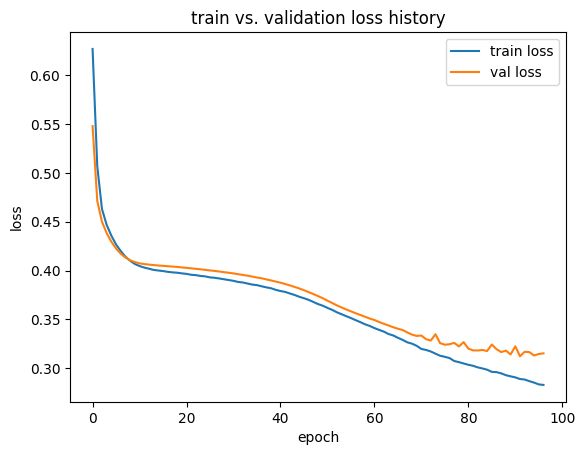

In [75]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [76]:
# reload the best model
model.load_state_dict(torch.load(saved_path))
model.to(device)

MultiLabelBiLSTM(
  (embedding): Embedding(24064, 200)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(200, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=33, bias=True)
)

In [77]:
def test_model(test_dl, model, loss_fn, threshold=0.5):
    test_loss = 0.0
    all_logits = []
    all_probs = []
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch, lengths in test_dl:
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)

            # Forward pass: get predicted probabilities
            logits = model(X_batch, lengths)  # Shape: (batch_size, num_classes)

            # Calculate loss for this batch
            loss = loss_fn(logits, y_batch)
            test_loss += loss.item()

            # Get predicted probabilities (our model already applies sigmoid)
            probs = logits

            # Convert probabilities to binary predictions using threshold
            preds = (probs >= threshold).float()

            # Collect outputs and ground truth for evaluation
            all_logits.append(logits.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())

    # Average test loss over batches
    test_loss /= len(test_dl)

    # Concatenate outputs from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)

    print(f"Test Loss: {test_loss:.4f}")
    return all_logits, all_probs, all_preds, all_true

In [78]:
# Evaluate the model on the test set using the test_model function
all_logits, all_probs, all_preds, all_true = test_model(test_dl, model, loss_fn, threshold=0.5)

# Create a list of output class names from the dataframe (excluding 'text_raw')
output_classes = list(df_loreal.columns[1:34])  # Adjust if needed

# Print classification metrics for each label
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=output_classes))

Test Loss: 0.3115
Classification Report:
                     precision    recall  f1-score   support

  dark_pigmentation       0.00      0.00      0.00       193
               acne       0.00      0.00      0.00       161
        eye_contour       0.81      0.78      0.79        91
        homogeneity       0.78      0.75      0.76       739
      lack_firmness       0.70      0.19      0.29       189
      lack_radiance       0.78      0.81      0.80       781
              pores       1.00      0.03      0.05       189
         fine_lines       0.00      0.00      0.00         3
wrinkles_fine-lines       0.73      0.74      0.74       428
       eye-wrinkles       0.75      0.73      0.74        74
      undereye-bags       0.83      0.64      0.73        76
            generic       0.00      0.00      0.00        10
              18-34       0.91      1.00      0.95      1134
              35-54       0.93      1.00      0.96      1163
              55-99       0.94      1.00   